In [1]:
import sys
import os
import yaml
working_dir = '/arc/project/st-ashapi01-1/git/afraz96/RADD/workflows/part2_version2'
sys.path.append(working_dir)
src_dir = os.path.join(working_dir, 'src')
sys.path.append(src_dir)
import train
import test
import utils
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import argparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.decomposition import PCA
import logging
import pickle
from sklearn import preprocessing
import math
import time
# Import the ML Models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost
from tensorflow.keras.models import Sequential, model_from_json
import tensorflow as tf

# Load in the Models and the data

In [2]:
all_models = []
for root, dirs, files in os.walk('test1/models'):
    for file in files:
        if file.endswith('.json'):
                json_file = open(root + '/' + file, 'r')
                loaded_model_json = json_file.read()
                loaded_model = model_from_json(loaded_model_json)
                all_models.append(loaded_model)
                json_file.close() 
        elif file.endswith('.pkl'):
            with open(root + '/' + file, 'rb') as f:
                all_models.append(pickle.load(f))
        elif file.endswith('.h5'):
            neural_net_weights = os.path.join(root, file)


The data to use

In [3]:
df = pd.read_excel('Data/X500R_Database_for_Aaron.xlsx')

In [4]:
df.head()

,Non-Targeted,IS,Group,Name,Chemical Formula,Isotope,Adduct/Charge,Gain/Loss,Precursor (Q1) Mass (Da),Fragment (Q3) Mass (Da),...,RT Window,Update RT,Report Largest Peak,Algorithm Input Type,Algorithm Name,Units,Use Area,Regression Type,Regression Weighting,Signal-to-Noise Algorithm
0,False,False,NaN,Methylhexanamine (DMAA 1),C7H17N,1,[M+H]+,NaN,115.1361,NaN,...,30,0,False,SingleTrace,MQ4,ng/mL,True,Linear,1 / x,RelativeNoise
1,False,False,NaN,Methylhexanamine (DMAA 1)_1,C7H17N,1,[M+H]+,NaN,115.1361,57.0725,...,30,0,False,SingleTrace,MQ4,ng/mL,True,Linear,1 / x,RelativeNoise
2,False,False,NaN,Methylhexanamine (DMAA 1)_2,C7H17N,1,[M+H]+,NaN,115.1361,41.0426,...,30,0,False,SingleTrace,MQ4,ng/mL,True,Linear,1 / x,RelativeNoise
3,False,False,NaN,Methylhexanamine (DMAA 1)_3,C7H17N,1,[M+H]+,NaN,115.1361,43.0581,...,30,0,False,SingleTrace,MQ4,ng/mL,True,Linear,1 / x,RelativeNoise
4,False,False,NaN,Methylhexanamine (DMAA 1)_4,C7H17N,1,[M+H]+,NaN,115.1361,55.0569,...,30,0,False,SingleTrace,MQ4,ng/mL,True,Linear,1 / x,RelativeNoise


In [5]:
config_path = os.path.join(working_dir, 'config', 'config.yaml')
with open(config_path) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

In [6]:
## Load configurations
model_index = 'Name'
model_y = 'Retention Time (min)'
model_X = config['model_X']

# Directories
working_dir = config['working_dir']
raw_data_dir = config['raw_data_dir']
linking_dir = config['linking_dir']
output_dir = config['output_dir']
default_output_dir = config['default_output_dir']

# Filenames
raw_data_filename = config['raw_data_filename']
linking_filename = config['linking_filename']
smiles_dict_filename = config['smiles_dict_filename']
output_filename = config['output_filename']

# ML Pipeline
model_names = config['model_names']

In [8]:
import smiles

In [11]:
# we only wish to retain the not missing prediction + no repeats
df.dropna(subset=[model_y], inplace=True)
print(df.shape)
df.drop_duplicates(subset=[model_index], inplace=True)
print(df.shape)

smiles_dict = smiles.load_smiles_dict(smiles_dict_filename)
df['SMILES'] = df[model_index].apply(lambda x: smiles.get_smiles_with_url(x, smiles_dict, smiles_dict_filename))
print(df.head())

(7002, 32)
(7002, 32)
HTTP error occurred for Methylhexanamine (DMAA 1): 404 Client Error: PUGREST.NotFound for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/Methylhexanamine%20(DMAA%201)/property/CanonicalSMILES/TXT
HTTP error occurred for Methylhexanamine (DMAA 1)_1: 404 Client Error: PUGREST.NotFound for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/Methylhexanamine%20(DMAA%201)_1/property/CanonicalSMILES/TXT
HTTP error occurred for Methylhexanamine (DMAA 1)_2: 404 Client Error: PUGREST.NotFound for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/Methylhexanamine%20(DMAA%201)_2/property/CanonicalSMILES/TXT
HTTP error occurred for Methylhexanamine (DMAA 1)_3: 404 Client Error: PUGREST.NotFound for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/Methylhexanamine%20(DMAA%201)_3/property/CanonicalSMILES/TXT
HTTP error occurred for Methylhexanamine (DMAA 1)_4: 404 Client Error: PUGREST.NotFound for url: https://pubchem.ncbi.nlm.nih.

In [12]:
df['SMILES'].isnull().sum()

6160

In [13]:
df.shape

(7002, 33)

In [14]:
df.to_csv(os.path.join(working_dir,'Data/X500R_SMILES.csv'), index=False)

If there is a space in the compound. There will be same SMILES

In [16]:
smiles_df = df[df['SMILES'].notnull()]

In [17]:
smiles_df['SMILES'].value_counts()

SMILES
CCCCCN1C=C(C2=CC=CC=C21)C(=O)NC(C(=O)N)C(C)(C)C           2
CCCCCN1C2=CC=CC=C2C(=N1)C(=O)NC(C(=O)N)C(C)(C)C           2
CN1CCC23C4C1CC5=C2C(=C(C=C5)O)OC3C(C=C4)O                 2
CC(C)C(C(=O)N)NC(=O)C1=NN(C2=CC=CC=C21)CC3=CC=C(C=C3)F    2
CC1=NN=C2N1C3=C(C=C(C=C3)Cl)C(=NC2)C4=CC=CC=C4            2
                                                         ..
CC1(C(C1(C)C)C(=O)C2=CN(C3=CC=CC=C32)CC4CCOCC4)C          1
CCC(=O)OC(CC1=CC=CC=C1)(C2=CC=CC=C2)C(C)CN(C)C            1
C1C2=CN=C(N2C3=C(C=C(C=C3)Cl)C(=N1)C4=CC=CC=C4F)CO        1
C1CC1CN2CCC34C5C(=O)CCC3(C2CC6=C4C(=C(C=C6)O)O5)O         1
CCCCCN1C=C(C2=CC=CC=C21)C(=O)NC(C(=O)OC)C(C)(C)C          1
Name: count, Length: 835, dtype: int64

In [21]:
smiles_df[['Name', 'Retention Time (min)', 'SMILES']]

,Name,Retention Time (min),SMILES
12,Tranylcypromine,5.450,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...
18,Amphetamine,3.560,CC(CC1=CC=CC=C1)N
24,Cathinone,2.800,CC(C(=O)C1=CC=CC=C1)N
30,Methamphetamine,3.820,CC(CC1=CC=CC=C1)NC
31,Methamphetamine_1,3.820,CC(CC1=CC=CC=C1)[NH2+]C
...,...,...,...
6948,"2,6-Xylidine",3.495,CC1=C(C(=CC=C1)C)N
6960,3-Desoxy-MDPV,5.448,CCCC(C(=O)C1=CC2=C(C=C1)OCC2)N3CCCC3
6972,"1-(2,6-Xylyl)-2-Thiourea",4.730,CC1=C(C(=CC=C1)C)NC(=S)N
6978,Coniine,2.977,CCCC1CCCCN1\nCCCC1CCCCN1\nCCCC1CCCCN1


In [20]:
smiles_df.columns

Index(['Non-Targeted', 'IS', 'Group', 'Name', 'Chemical Formula', 'Isotope',
       'Adduct/Charge', 'Gain/Loss', 'Precursor (Q1) Mass (Da)',
       'Fragment (Q3) Mass (Da)', 'Start - Stop', 'XIC Width (Da)',
       'Retention Time (min)', 'IS Name', 'Experiment Index', 'Min Peak Width',
       'Min Peak Height', 'S/N Integration Threshold', 'Smoothing Width',
       'Noise Percentage', 'Baseline Sub. Window', 'Peak Splitting Factor',
       'RT Window', 'Update RT', 'Report Largest Peak', 'Algorithm Input Type',
       'Algorithm Name', 'Units', 'Use Area', 'Regression Type',
       'Regression Weighting', 'Signal-to-Noise Algorithm', 'SMILES'],
      dtype='object')

Exclude Duplicates

In [ ]:
smiles_df['']

In [25]:
smiles_no_dups_df = smiles_df[smiles_df['Fragment (Q3) Mass (Da)'].isnull()]

In [26]:
smiles_no_dups_df.shape

(819, 33)

In [28]:
smiles_no_dups_df[['Name', 'Retention Time (min)', 'SMILES']]

,Name,Retention Time (min),SMILES
12,Tranylcypromine,5.450,C1C(C1N)C2=CC=CC=C2\nC1C(C1N)C2=CC=CC=C2\nC1C(...
18,Amphetamine,3.560,CC(CC1=CC=CC=C1)N
24,Cathinone,2.800,CC(C(=O)C1=CC=CC=C1)N
30,Methamphetamine,3.820,CC(CC1=CC=CC=C1)NC
36,Phentermine,4.170,CC(C)(CC1=CC=CC=C1)N
...,...,...,...
6948,"2,6-Xylidine",3.495,CC1=C(C(=CC=C1)C)N
6960,3-Desoxy-MDPV,5.448,CCCC(C(=O)C1=CC2=C(C=C1)OCC2)N3CCCC3
6972,"1-(2,6-Xylyl)-2-Thiourea",4.730,CC1=C(C(=CC=C1)C)NC(=S)N
6978,Coniine,2.977,CCCC1CCCCN1\nCCCC1CCCCN1\nCCCC1CCCCN1


Bin the Error:
- 1 min
- 2 min
- More than 2 min

In [29]:
bccdc_df = pd.read_csv(os.path.join(working_dir,'Data/training_data_bccdc.csv'))

In [30]:
bccdc_df.head()

,Compound,Compound Name,Workflow,Associated Target Peak,MS Order,Precursor m/z,Product m/z,m/z,Height Threshold,Area Threshold,...,Window Type,PeakPolarity,Adduct,Charge State,Retention Time,Retention Time Window,Integration Strategy,PTC Confirmed RT,Stripped Compound Name,SMILES
0,Ketamine,(-)-Ketamine,TargetPeak,NaN,ms1,238.09932,238.09932,238.09932,5000,5000,...,eAbsolute,Positive,M+H,1.0,3.77,30.0,Individual,3.99,Ketamine,CNC1(CCCCC1=O)C2=CC=CC=C2Cl
1,10-hydroxycarbazepine,10-hydroxycarbazepine,TargetPeak,NaN,ms1,255.11280,255.11280,255.11280,5000,5000,...,eAbsolute,Positive,M+H,1.0,4.71,30.0,Individual,4.90,10hydroxycarbazepine,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O
2,6-Monoacetylmorphine,6-Monoacetylmorphine,TargetPeak,NaN,ms1,328.15433,328.15433,328.15433,5000,5000,...,eAbsolute,Positive,M+H,1.0,3.26,30.0,Individual,3.58,6Monoacetylmorphine,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)O)CCN3C
3,7-Aminoclonazepam,7-Aminoclonazepam,TargetPeak,NaN,ms1,286.07417,286.07417,286.07417,5000,5000,...,eAbsolute,Positive,M+H,1.0,4.06,30.0,Individual,4.28,7Aminoclonazepam,C1C(=O)NC2=C(C=C(C=C2)N)C(=N1)C3=CC=CC=C3Cl
4,7-Aminoflunitrazepam,7-Aminoflunitrazepam,TargetPeak,NaN,ms1,284.11937,284.11937,284.11937,5000,5000,...,eAbsolute,Positive,M+H,1.0,4.54,30.0,Individual,4.69,7Aminoflunitrazepam,CN1C(=O)CN=C(C2=C1C=CC(=C2)N)C3=CC=CC=C3F


In [45]:
bccdc_df.dropna(subset=[model_X], inplace=True)

In [31]:
model_index = config['model_index']
model_y = config['model_y']
model_X = config['model_X']

In [37]:
# Instaniate the Encoder
vectorizer = train.SMILESVectorizer()


In [46]:
# Fit the vectorizer on the training data
vectorizer.fit(bccdc_df[model_X].to_list())

max_smiles_length: [27, 38, 45, 43, 41, 58, 43, 43, 43, 51, 46, 21, 57, 36, 50, 42, 17, 33, 31, 37, 40, 41, 42, 36, 33, 67, 33, 51, 36, 53, 30, 42, 36, 38, 47, 44, 39, 54, 45, 40, 41, 42, 37, 41, 47, 32, 44, 44, 53, 37, 33, 32, 41, 33, 53, 33, 51, 110, 36, 34, 44, 44, 52, 47, 47, 52, 52, 50, 91, 21, 59, 64, 21, 42, 41, 34, 45, 35, 62, 431, 38, 26, 20, 29, 67, 47, 43, 37, 25, 32, 25, 45, 17, 44, 18, 35, 29, 29, 35, 30, 24, 47, 36, 51, 41, 47, 49, 19, 52, 59, 42, 29, 41, 30, 29, 43, 33, 66, 34, 40, 34, 43, 45, 44, 44, 39, 46, 31, 32, 21, 83, 41, 18, 29, 44, 36, 40, 46, 32, 21, 44, 42, 55, 40, 64, 46, 44, 41, 44, 32, 48, 48, 50, 37, 37, 38, 125, 65, 35, 60, 49, 27, 46, 55, 47, 52]
Charset Size: 39
Char to Int Mapping: {'l': 1, 'y': 2, '@': 3, '3': 4, 'H': 5, 'S': 6, 'F': 7, 'C': 8, 'r': 9, 's': 10, '/': 11, 'c': 12, 'o': 13, '+': 14, 'I': 15, '5': 16, '(': 17, '2': 18, ')': 19, '9': 20, 'i': 21, '#': 22, '6': 23, '8': 24, '4': 25, '=': 26, '1': 27, 'O': 28, '[': 29, 'D': 30, 'B': 31, ']':

In [47]:
bccdc_df_vectorized, _ = vectorizer.transform(bccdc_df[model_X].to_list())

# Flatten and create feature names
bccdc_df_flattened = train.flatten_and_create_feature_names(bccdc_df_vectorized)

# Combine with additional features (assuming no additional features in this example)
combined_bccdc_df = train.combine_with_additional_features(bccdc_df_flattened, None)

In [50]:
with open('test1/processor.pkl', 'rb') as f:
    processor = pickle.load(f)

In [51]:
norm_X = processor.transform(combined_bccdc_df)

In [52]:
for model in all_models:
    print(model.predict(norm_X))

[4.50188664 5.1044951  4.49190604 5.01460223 4.97391754 5.03128021
 4.86226687 5.3184473  4.93403571 4.76388547 5.84382831 4.04887541
 5.02297908 5.42119885 5.37163885 5.38383526 3.45924012 4.23652635
 5.05335812 5.10146649 4.47236883 5.52692211 5.33605231 4.7328024
 5.0680115  5.27838776 4.88673143 4.95106304 5.12479147 4.86013793
 4.77484142 4.769907   4.73145459 5.21838712 5.01438481 5.56009018
 5.46709714 5.49733441 5.04305641 4.91677998 4.47418831 3.76545975
 4.8208008  5.33328323 4.83836277 5.13639823 5.14262004 4.69022683
 5.50033112 3.75834212 4.7798228  4.77573832 5.87184436 5.62948163
 5.1593968  4.72097042 5.34846802 5.39595202 4.64038557 5.21276291
 5.0264761  5.43573724 5.02414592 5.84382831 5.85384879 5.40278515
 5.73050848 5.2636241  5.32564233 3.76312954 5.53748277 6.61428293
 3.59340212 3.73397641 3.59917315 4.87779291 5.2413046  5.30246724
 4.99616145 5.48917531 4.63279605 4.25259218 4.39751395 4.26289263
 5.73981397 4.9912972  5.13481689 5.13063281 4.05843214 5.03255

In [55]:
bccdc_ml_cols = []
for i,name in enumerate(model_names):
    bccdc_ml_cols.append(name + '_prediction')
    bccdc_df[name + '_prediction'] = all_models[i].predict(norm_X)

[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
6/6 [==============================] - 0s 2ms/step


In [56]:
bccdc_df.head()

,Compound,Compound Name,Workflow,Associated Target Peak,MS Order,Precursor m/z,Product m/z,m/z,Height Threshold,Area Threshold,...,Integration Strategy,PTC Confirmed RT,Stripped Compound Name,SMILES,CatBoost_prediction,Lasso_prediction,LGBM_prediction,Neural Network_prediction,Random Forest_prediction,XGBoost_prediction
0,Ketamine,(-)-Ketamine,TargetPeak,NaN,ms1,238.09932,238.09932,238.09932,5000,5000,...,Individual,3.99,Ketamine,CNC1(CCCCC1=O)C2=CC=CC=C2Cl,4.501887,4.558544,4.178472,0.274435,4.568798,4.005203
1,10-hydroxycarbazepine,10-hydroxycarbazepine,TargetPeak,NaN,ms1,255.11280,255.11280,255.11280,5000,5000,...,Individual,4.90,10hydroxycarbazepine,C1C(C2=CC=CC=C2N(C3=CC=CC=C31)C(=O)N)O,5.104495,5.238754,5.465169,0.038953,5.152843,4.901889
2,6-Monoacetylmorphine,6-Monoacetylmorphine,TargetPeak,NaN,ms1,328.15433,328.15433,328.15433,5000,5000,...,Individual,3.58,6Monoacetylmorphine,CC(=O)OC1C=CC2C3CC4=C5C2(C1OC5=C(C=C4)O)CCN3C,4.491906,4.598148,4.915864,0.219250,4.781701,3.587502
3,7-Aminoclonazepam,7-Aminoclonazepam,TargetPeak,NaN,ms1,286.07417,286.07417,286.07417,5000,5000,...,Individual,4.28,7Aminoclonazepam,C1C(=O)NC2=C(C=C(C=C2)N)C(=N1)C3=CC=CC=C3Cl,5.014602,4.998131,5.205069,0.307948,5.020960,4.293420
4,7-Aminoflunitrazepam,7-Aminoflunitrazepam,TargetPeak,NaN,ms1,284.11937,284.11937,284.11937,5000,5000,...,Individual,4.69,7Aminoflunitrazepam,CN1C(=O)CN=C(C2=C1C=CC(=C2)N)C3=CC=CC=C3F,4.973918,4.871542,4.755930,0.009416,5.038324,4.704114


In [58]:
# Calculate errors
for model in model_names:
    bccdc_df[f'{model}_error'] = abs(bccdc_df[model+'_prediction'] - bccdc_df[model_y])



In [60]:
# Convert to long format manually
long_data = []
for index, row in bccdc_df.iterrows():
    for model in model_names:
        if model != 'model_y':
            long_data.append({
                'model_y': row[model_y],
                'model': model,
                'prediction': row[model+'_prediction'],
                'error': row[f'{model}_error'],
                'under_over': 'Under' if row[model+'_prediction'] < row[model_y] else 'Over'
            })

df_long = pd.DataFrame(long_data)

# Function to bin errors
def bin_errors(error):
    if error <= 1.0:
        return '<= 1.0'
    elif 1.0 < error <= 2.0:
        return '> 1.0 and <= 2.0'
    else:
        return '> 2.0'

# Apply binning
df_long['error_bin'] = df_long['error'].apply(bin_errors)

In [61]:
df_long

,model_y,model,prediction,error,under_over,error_bin
0,3.99,CatBoost,4.501887,0.511887,Over,<= 1.0
1,3.99,Lasso,4.558544,0.568544,Over,<= 1.0
2,3.99,LGBM,4.178472,0.188472,Over,<= 1.0
3,3.99,Neural Network,0.274435,3.715565,Under,> 2.0
4,3.99,Random Forest,4.568798,0.578798,Over,<= 1.0
...,...,...,...,...,...,...
991,4.08,Lasso,4.974246,0.894246,Over,<= 1.0
992,4.08,LGBM,5.241987,1.161987,Over,> 1.0 and <= 2.0
993,4.08,Neural Network,0.428617,3.651383,Under,> 2.0
994,4.08,Random Forest,4.943907,0.863907,Over,<= 1.0


In [62]:
df_long['error_bin'].value_counts()

error_bin
<= 1.0              739
> 2.0               174
> 1.0 and <= 2.0     83
Name: count, dtype: int64

In [64]:
import seaborn as sns

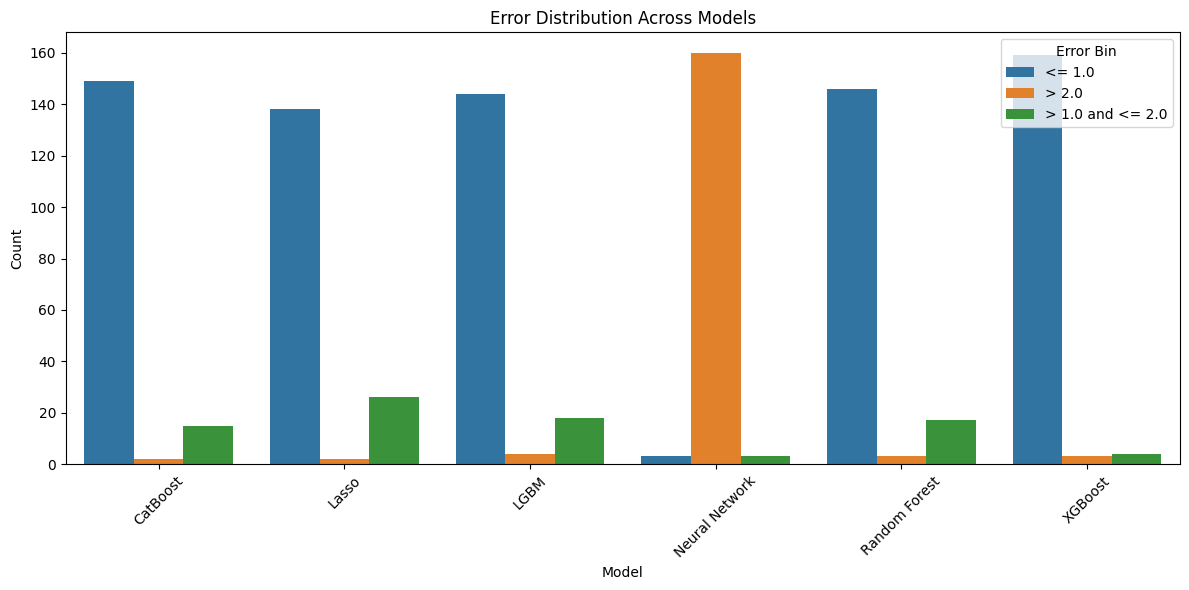

In [65]:
# Plotting with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(data=df_long, x='model', hue='error_bin')
plt.title('Error Distribution Across Models')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Error Bin')
plt.tight_layout()
plt.show()